In [35]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load the CSV files
df_curated = pd.read_csv('train_curated.csv')
df_noisy = pd.read_csv('train_noisy.csv')
df_siren = pd.read_csv('siren.csv')
df_carhorn = pd.read_csv('car_horn.csv')
# Paths to the audio files
try:
    audio_path_curated = 'C:/Users/SJ/Documents/GitHub/DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_curated'
    audio_path_noisy = 'C:/Users/SJ/Documents/GitHub/DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_noisy'
    print("WINDOWS")
except:
    audio_path_curated = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_curated'
    audio_path_noisy = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_noisy'
    print("MAC")

# Concatenate the DataFrames
df = pd.concat([df_curated,df_noisy,df_siren,df_carhorn], ignore_index=True)
df

WINDOWS


,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping
...,...,...
26138,99812-1-2-0.wav,car_horn
26139,99812-1-3-0.wav,car_horn
26140,99812-1-4-0.wav,car_horn
26141,99812-1-5-0.wav,car_horn


In [36]:
import librosa
import warnings
import os
def drop_unloadable_files(df, audio_dir):
    count = 0

    # Iterate over the DataFrame
    for i, row in df.iterrows():
        audio_file = os.path.join(audio_dir, row['fname'])
        try:
            # Try to load the audio file
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                librosa.load(audio_file, sr=None)
        except Exception:
            # If loading fails, drop the row
            df = df.drop(i)
            count = count + 1
    print("droped : ",count)
    return df

# Drop rows with unloadable audio files from the curated and noisy DataFrames
df_curated = drop_unloadable_files(df_curated, audio_path_curated)
df_noisy = drop_unloadable_files(df_noisy, audio_path_noisy)

# Concatenate the curated and noisy DataFrames
df_concat = pd.concat([df_curated, df_noisy,df_siren,df_carhorn], ignore_index=True)
df_concat.to_csv('csv_train_concat_drop.csv', index=False)
df_concat

droped :  0
droped :  1631


,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping
...,...,...
24507,99812-1-2-0.wav,car_horn
24508,99812-1-3-0.wav,car_horn
24509,99812-1-4-0.wav,car_horn
24510,99812-1-5-0.wav,car_horn


In [66]:
## You can start from here
import pandas as pd

try:
    # Split the labels on the commas to create a list of labels for each sample
    df_concat['labels'] = df_concat['labels'].str.split(',')
    print("try")
except:
    #### SKIPP ####
    #if you dont run the drop code (since it takes too long)
    df_concat = pd.read_csv('csv_train_concat_drop.csv')
    df_concat['labels'] = df_concat['labels'].str.split(',')
    print('load concat csv')
df = df_concat
df_concat = 0 #delete df_concat so that if we run again , try would make an error (intentionally)
df

load concat csv


,fname,labels
0,0006ae4e.wav,[Bark]
1,0019ef41.wav,[Raindrop]
2,001ec0ad.wav,[Finger_snapping]
3,0026c7cb.wav,[Run]
4,0026f116.wav,[Finger_snapping]
...,...,...
24507,99812-1-2-0.wav,[car_horn]
24508,99812-1-3-0.wav,[car_horn]
24509,99812-1-4-0.wav,[car_horn]
24510,99812-1-5-0.wav,[car_horn]


(siren                              929
 car_horn                           429
 Bark                               354
 Car_passing_by                     352
 Bus                                351
 Traffic_noise_and_roadway_noise    351
 Shatter                            350
 Knock                              348
 Slam                               347
 Motorcycle                         346
 Yell                               346
 Screaming                          345
 Bicycle_bell                       336
 Name: labels, dtype: int64,
 <Axes: >)

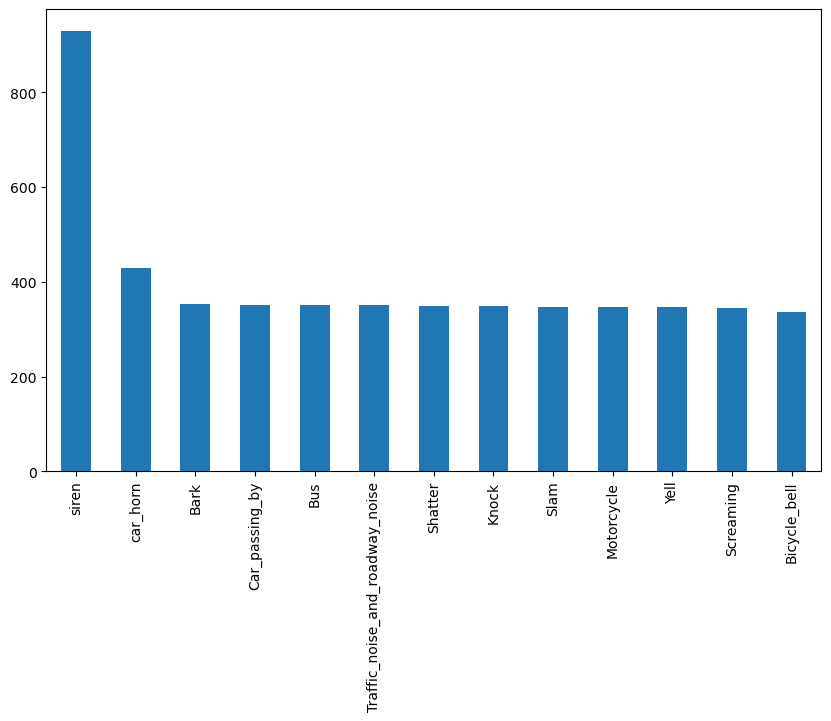

In [67]:
# Explode the DataFrame on the 'labels' column
df_exploded = df.explode('labels')

# Select the labels
selected_labels = ['Motorcycle', 'Slam', 'Yell', 'Screaming', 'Bus',
                   'Traffic_noise_and_roadway_noise', 'Car_passing_by',
                   'Bicycle_bell', 'Knock', 'Bark', 'Scream', 'Shatter','siren','car_horn']

# Filter the data
df_filtered = df_exploded[df_exploded['labels'].isin(selected_labels)]

# Count the number of occurrences of each label
label_counts = df_filtered['labels'].value_counts()

label_counts, label_counts.plot(kind='bar', figsize=(10, 6))


In [68]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
#df = df_filtered
# Filter the dataframe to only include rows with the selected labels
df = df[df['labels'].apply(lambda x: any([label in x for label in selected_labels]))]

# Create a new DataFrame containing only the filtered labels
labels_df = df['labels'].apply(lambda x: [label for label in x if label in selected_labels])

# One-hot encode the labels
df = df.join(pd.DataFrame(mlb.fit_transform(labels_df),
                          columns=mlb.classes_,
                          index=df.index))

# Drop the 'labels' column
df = df.drop(columns=['labels'])

df

,fname,Bark,Bicycle_bell,Bus,Car_passing_by,Knock,Motorcycle,Screaming,Shatter,Slam,Traffic_noise_and_roadway_noise,Yell,car_horn,siren
0,0006ae4e.wav,1,0,0,0,0,0,0,0,0,0,0,0,0
14,00c40a6d.wav,0,0,0,0,1,0,0,0,0,0,0,0,0
15,00c4e82c.wav,0,0,0,0,0,1,0,0,0,0,0,0,0
23,015a50b9.wav,1,0,0,0,0,0,0,0,0,0,0,0,0
31,02286d70.wav,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24507,99812-1-2-0.wav,0,0,0,0,0,0,0,0,0,0,0,1,0
24508,99812-1-3-0.wav,0,0,0,0,0,0,0,0,0,0,0,1,0
24509,99812-1-4-0.wav,0,0,0,0,0,0,0,0,0,0,0,1,0
24510,99812-1-5-0.wav,0,0,0,0,0,0,0,0,0,0,0,1,0


In [69]:
print("label count :",end='')
len(mlb.classes_)

label count :

13

In [70]:
#Cut audio
import os
import numpy as np
import librosa

def load_audio(fname, sr=22050):
    # Paths to the audio files
    audio_path_curated = 'train_curated'  # Adjust these paths according to your directory structure
    audio_path_noisy = 'train_noisy'  # Adjust these paths according to your directory structure

    # Check if the file exists in the curated directory
    if os.path.exists(os.path.join(audio_path_curated, fname)):
        filename = os.path.join(audio_path_curated, fname)
    # Otherwise, check the noisy directory
    elif os.path.exists(os.path.join(audio_path_noisy, fname)):
        filename = os.path.join(audio_path_noisy, fname)
    else:
        raise FileNotFoundError(f"{fname} not found in both directories.")
    
    # Load the audio file
    y, _ = librosa.load(filename, sr=sr)
    
    return y


In [71]:
#  Augment audio
# 1. random streach
# 2. cut in 2 'durcation' seconds (in random position)
# 3. random pich shift
# 4. random noise 

import random

def augment_audio(y, duration=2, sr=22050): #ducation = 2seconds
    # Apply time stretching
    rate = random.uniform(0.9, 1.1)  # Randomly vary the speed between 80% and 120%
    y = librosa.effects.time_stretch(y, rate = rate)

    ## Cut audio
    # If the audio is too short, pad it with zeros
    if len(y) < sr * duration:
        y = np.pad(y, (0, int(sr * duration) - len(y)))
    
    # If the audio is too long, randomly select a segment
    if len(y) > sr * duration:
        max_start_index = len(y) - int(sr * duration) #audio lengh - 2 seconds
        start_index = np.random.randint(0, max_start_index) # start anywhere except the last 2 seconds
        y = y[start_index:start_index + int(sr * duration)] # cut anywhere 2 seconds

    # Apply pitch shifting
    steps = random.randint(-1, 1)  # Randomly vary the pitch by up to n semitones
    y = librosa.effects.pitch_shift(y, sr = sr , n_steps= steps)

    # Apply additive noise
    noise = np.random.normal(0, 0.01, len(y))  # White noise with a standard deviation of 0.1
    y += noise
    
    return y

In [72]:
def get_mel_spectrogram(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # Compute the spectrogram
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D_abs = np.abs(D)
    # Convert to Mel scale
    mel_spec = librosa.feature.melspectrogram(S=librosa.amplitude_to_db(D_abs), sr=sr, n_mels=n_mels)
    # Normalize
    mel_spec = (mel_spec - np.mean(mel_spec)) / np.std(mel_spec)
    return mel_spec

In [51]:
from tqdm import tqdm
# 1. load audio
# 2. augment audio
# 3. get mel spectrogram
# 4. extend a new labels (since it got bigger)

spectrograms = []
labels = []
print("if the number doesnt increase ,stop the code and run the vscode with admin")
# Load, cut, augment, and get the spectrogram of each audio file 10 times
for i in tqdm(range(len(df))):
    filename = df.iloc[i]['fname']
    label = df.iloc[i].drop('fname').values  # Get the label of the audio file
    # Load and cut the audio
    y = load_audio(filename)
    
    for _ in range(3):    
        # Augment the audio
        y_aug = augment_audio(y,duration=2)
        
        # Get the spectrogram of the augmented audio
        mel_spec = get_mel_spectrogram(y_aug)
        
        # Add the spectrogram to the list
        spectrograms.append(mel_spec)
        
        # Add the label to the list
        labels.append(label)


if the number doesnt increase ,stop the code and run the vscode with admin


 93%|█████████▎| 4711/5061 [21:07<00:33, 10.50it/s]c:\ProgramData\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
100%|█████████▉| 5038/5061 [21:56<00:02,  8.55it/s]c:\ProgramData\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
100%|█████████▉| 5040/5061 [21:56<00:02,  9.54it/s]c:\ProgramData\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 5061/5061 [21:59<00:00,  3.84it/s]


In [53]:
# Convert the list of spectrograms and labels to numpy arrays
spectrograms = np.array(spectrograms)
spectrograms[0]

array([[ 2.79442   ,  1.7331772 ,  2.2051938 , ...,  2.279593  ,
        -0.36564645, -2.2140405 ],
       [ 4.0046115 ,  4.9025083 ,  4.6059484 , ...,  0.45981637,
        -2.7780347 , -3.433365  ],
       [ 2.0856059 ,  3.1232657 ,  3.2347822 , ..., -0.25546935,
        -1.2753102 , -0.62225807],
       ...,
       [-0.65993476, -0.385116  , -0.12038442, ...,  0.35345322,
        -0.00870939, -0.22241879],
       [-0.546549  , -0.05254431, -0.4851783 , ...,  0.12559652,
        -0.44097492, -0.75552255],
       [-0.86536986, -0.2098081 , -0.19708656, ..., -0.22394435,
        -0.33812565, -0.76979554]], dtype=float32)

In [54]:
# Save both npy (since it takes too long to make)
np.save('np_spectrograms.npy', spectrograms)
np.save('np_labels_aug.npy',labels)

In [73]:
# Load the spectrograms array from the .npy file
spectrograms_loaded = np.load('np_spectrograms.npy')
labels = np.load('np_labels_aug.npy', allow_pickle=True)

In [74]:
# Check length
print(len(spectrograms_loaded),end=',')
print(len(spectrograms_loaded[0]),end=',')
print(len(spectrograms_loaded[0][0]))
print(len(labels),end=',')
print(len(labels[0]),end=',')

15183,128,87
15183,13,

In [87]:
#if use CNN type 1, if use resnet 18 type 2 , resnet 34 is type 3
def ModelSelect(select):

    if select == 1:
        import torch
        import torch.nn as nn

        class AudioClassifier(nn.Module):
            def __init__(self):
                super(AudioClassifier, self).__init__()
                self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
                self.bn1 = nn.BatchNorm2d(64)  # Add batch normalization
                self.dropout1 = nn.Dropout(0.2)  # Add dropout layer

                self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
                self.bn2 = nn.BatchNorm2d(128)  # Add batch normalization
                self.dropout2 = nn.Dropout(0.2)  # Add dropout layer

                self.fc1 = nn.Linear(128*32*21, 1024)
                self.dropout3 = nn.Dropout(0.5)  # Add dropout layer

                self.fc2 = nn.Linear(1024, len(mlb.classes_))

            def forward(self, x):
                x = x.unsqueeze(1)  # Add an extra dimension for the single channel
                x = self.dropout1(torch.relu(self.bn1(self.conv1(x))))
                x = torch.max_pool2d(x, 2)
                x = self.dropout2(torch.relu(self.bn2(self.conv2(x))))
                x = torch.max_pool2d(x, 2)
                x = x.view(x.size(0), -1)  # Flatten the tensor
                x = self.dropout3(torch.relu(self.fc1(x)))
                x = self.fc2(x)
                return x

        model = AudioClassifier()

        print("CNN")
    if select == 2:
        import torch
        import torch.nn as nn
        from torchvision import models

        class AudioClassifier(nn.Module):
            def __init__(self, num_classes):
                super(AudioClassifier, self).__init__()
                self.resnet = models.resnet18(pretrained=True)
                
                # Modify first layer to take 1-channel input
                self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                
                # Modify last layer to have the correct number of output classes
                num_features = self.resnet.fc.in_features
                self.resnet.fc = nn.Linear(num_features, num_classes)

            def forward(self, x):
                x = x.unsqueeze(1)  # Add an extra dimension for the single channel
                x = self.resnet(x)
                return x

        model = AudioClassifier(num_classes=len(mlb.classes_))
        print("Resnet18")
    if select == 3:
        import torch
        import torch.nn as nn
        from torchvision import models

        class AudioClassifier(nn.Module):
            def __init__(self, num_classes):
                super(AudioClassifier, self).__init__()
                self.resnet = models.resnet34(pretrained=True)
                
                # Modify first layer to take 1-channel input
                self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                
                # Modify last layer to have the correct number of output classes
                num_features = self.resnet.fc.in_features
                self.resnet.fc = nn.Linear(num_features, num_classes)

            def forward(self, x):
                x = x.unsqueeze(1)  # Add an extra dimension for the single channel
                x = self.resnet(x)
                return x

        model = AudioClassifier(num_classes=len(mlb.classes_))
        print("Resnet34")
    return model

In [77]:
# Check if the model is loading successfully
for i in range(1,4):
    print(i)
    model = ModelSelect(i)

1
CNN
2
Resnet18
3


c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-

Resnet34


In [78]:
from sklearn.model_selection import train_test_split
import numpy as np


# Convert the spectrograms and labels to numpy arrays
X = np.array(spectrograms)
y = np.array(labels)

# Change dtype of y to int
y = y.astype(int)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [79]:
import torch
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32 # If error, reduce this number


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Convert the training and validation sets to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create PyTorch datasets from the tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create PyTorch dataloaders from the datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


1
CNN
device :  cuda


100%|██████████| 380/380 [01:57<00:00,  3.23it/s]


Save model 1
Epoch 1/20, Train Loss: 0.60275, Val Loss: 0.28220, Elapsed Time: 120.16s, Estimated Time Left: 2282.99s


100%|██████████| 380/380 [01:57<00:00,  3.24it/s]


Save model 1
Epoch 2/20, Train Loss: 0.28237, Val Loss: 0.25026, Elapsed Time: 119.90s, Estimated Time Left: 2158.12s


100%|██████████| 380/380 [01:57<00:00,  3.23it/s]


Save model 1
Epoch 3/20, Train Loss: 0.24761, Val Loss: 0.23937, Elapsed Time: 120.10s, Estimated Time Left: 2041.72s


100%|██████████| 380/380 [01:55<00:00,  3.30it/s]


Epoch 4/20, Train Loss: 0.23284, Val Loss: 0.24043, Elapsed Time: 117.35s, Estimated Time Left: 1877.65s


100%|██████████| 380/380 [01:57<00:00,  3.24it/s]


Epoch 5/20, Train Loss: 0.22739, Val Loss: 0.24917, Elapsed Time: 119.43s, Estimated Time Left: 1791.41s


100%|██████████| 380/380 [01:56<00:00,  3.26it/s]


Epoch 6/20, Train Loss: 0.22881, Val Loss: 0.25285, Elapsed Time: 118.53s, Estimated Time Left: 1659.43s


100%|██████████| 380/380 [01:56<00:00,  3.26it/s]


Epoch 7/20, Train Loss: 0.22935, Val Loss: 0.28130, Elapsed Time: 118.63s, Estimated Time Left: 1542.23s


100%|██████████| 380/380 [01:56<00:00,  3.26it/s]


Epoch 8/20, Train Loss: 0.22966, Val Loss: 0.25921, Elapsed Time: 118.70s, Estimated Time Left: 1424.39s


100%|██████████| 380/380 [01:56<00:00,  3.27it/s]


Epoch 9/20, Train Loss: 0.22814, Val Loss: 0.24480, Elapsed Time: 118.44s, Estimated Time Left: 1302.87s


100%|██████████| 380/380 [01:56<00:00,  3.27it/s]


Epoch 10/20, Train Loss: 0.22471, Val Loss: 0.25613, Elapsed Time: 118.40s, Estimated Time Left: 1183.98s


100%|██████████| 380/380 [01:56<00:00,  3.26it/s]


Save model 1
Epoch 11/20, Train Loss: 0.22135, Val Loss: 0.22966, Elapsed Time: 119.11s, Estimated Time Left: 1072.03s


100%|██████████| 380/380 [01:56<00:00,  3.27it/s]


Epoch 12/20, Train Loss: 0.21912, Val Loss: 0.24558, Elapsed Time: 118.40s, Estimated Time Left: 947.21s


100%|██████████| 380/380 [01:56<00:00,  3.26it/s]


Epoch 13/20, Train Loss: 0.21789, Val Loss: 0.22974, Elapsed Time: 118.48s, Estimated Time Left: 829.33s


100%|██████████| 380/380 [01:56<00:00,  3.26it/s]


Save model 1
Epoch 14/20, Train Loss: 0.21652, Val Loss: 0.22721, Elapsed Time: 119.02s, Estimated Time Left: 714.12s


100%|██████████| 380/380 [01:56<00:00,  3.27it/s]


Epoch 15/20, Train Loss: 0.21692, Val Loss: 0.23632, Elapsed Time: 118.43s, Estimated Time Left: 592.14s


100%|██████████| 380/380 [01:56<00:00,  3.27it/s]


Epoch 16/20, Train Loss: 0.21590, Val Loss: 0.22758, Elapsed Time: 118.43s, Estimated Time Left: 473.73s


100%|██████████| 380/380 [01:56<00:00,  3.26it/s]


Save model 1
Epoch 17/20, Train Loss: 0.21533, Val Loss: 0.21567, Elapsed Time: 118.96s, Estimated Time Left: 356.89s


100%|██████████| 380/380 [01:56<00:00,  3.27it/s]


Epoch 18/20, Train Loss: 0.21437, Val Loss: 0.23053, Elapsed Time: 118.43s, Estimated Time Left: 236.86s


100%|██████████| 380/380 [01:56<00:00,  3.27it/s]


Epoch 19/20, Train Loss: 0.21490, Val Loss: 0.23616, Elapsed Time: 118.39s, Estimated Time Left: 118.39s


100%|██████████| 380/380 [01:56<00:00,  3.25it/s]


Epoch 20/20, Train Loss: 0.21493, Val Loss: 0.23216, Elapsed Time: 118.98s, Estimated Time Left: 0.00s
Finished Training


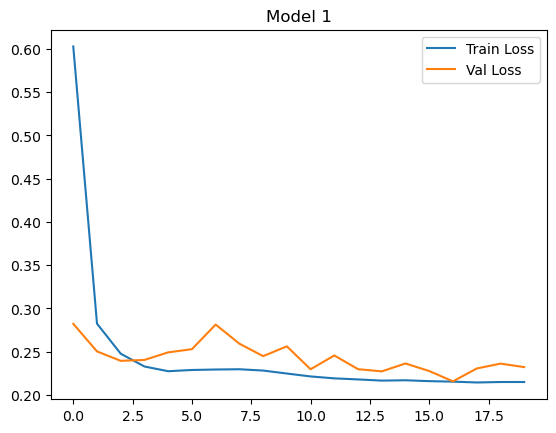

2
Resnet18
device :  cuda


100%|██████████| 380/380 [00:24<00:00, 15.74it/s]


Save model 2
Epoch 1/20, Train Loss: 0.23826, Val Loss: 0.27183, Elapsed Time: 25.81s, Estimated Time Left: 490.31s


100%|██████████| 380/380 [00:24<00:00, 15.64it/s]


Save model 2
Epoch 2/20, Train Loss: 0.22184, Val Loss: 0.23028, Elapsed Time: 25.92s, Estimated Time Left: 466.58s


100%|██████████| 380/380 [00:24<00:00, 15.75it/s]


Save model 2
Epoch 3/20, Train Loss: 0.20796, Val Loss: 0.21612, Elapsed Time: 25.76s, Estimated Time Left: 438.00s


100%|██████████| 380/380 [00:24<00:00, 15.77it/s]


Epoch 4/20, Train Loss: 0.20473, Val Loss: 0.22208, Elapsed Time: 25.68s, Estimated Time Left: 410.83s


100%|██████████| 380/380 [00:24<00:00, 15.76it/s]


Epoch 5/20, Train Loss: 0.20639, Val Loss: 0.22024, Elapsed Time: 25.70s, Estimated Time Left: 385.48s


100%|██████████| 380/380 [00:24<00:00, 15.68it/s]


Save model 2
Epoch 6/20, Train Loss: 0.21129, Val Loss: 0.21414, Elapsed Time: 25.89s, Estimated Time Left: 362.50s


100%|██████████| 380/380 [00:24<00:00, 15.38it/s]


Epoch 7/20, Train Loss: 0.22064, Val Loss: 0.27249, Elapsed Time: 26.30s, Estimated Time Left: 341.94s


100%|██████████| 380/380 [00:56<00:00,  6.67it/s]


Epoch 8/20, Train Loss: 0.22681, Val Loss: 0.23718, Elapsed Time: 69.86s, Estimated Time Left: 838.33s


100%|██████████| 380/380 [02:13<00:00,  2.85it/s]


Epoch 9/20, Train Loss: 0.23090, Val Loss: 0.24160, Elapsed Time: 139.00s, Estimated Time Left: 1529.05s


100%|██████████| 380/380 [01:01<00:00,  6.13it/s]


Epoch 10/20, Train Loss: 0.23676, Val Loss: 0.24259, Elapsed Time: 66.14s, Estimated Time Left: 661.41s


100%|██████████| 380/380 [01:00<00:00,  6.24it/s]


Epoch 11/20, Train Loss: 0.23674, Val Loss: 0.23979, Elapsed Time: 64.12s, Estimated Time Left: 577.08s


100%|██████████| 380/380 [00:59<00:00,  6.35it/s]


Epoch 12/20, Train Loss: 0.23391, Val Loss: 0.23702, Elapsed Time: 61.46s, Estimated Time Left: 491.70s


100%|██████████| 380/380 [00:24<00:00, 15.57it/s]


Epoch 13/20, Train Loss: 0.23217, Val Loss: 0.23345, Elapsed Time: 26.01s, Estimated Time Left: 182.10s


100%|██████████| 380/380 [00:24<00:00, 15.76it/s]


Epoch 14/20, Train Loss: 0.23112, Val Loss: 0.22970, Elapsed Time: 25.71s, Estimated Time Left: 154.24s


100%|██████████| 380/380 [00:24<00:00, 15.74it/s]


Epoch 15/20, Train Loss: 0.23049, Val Loss: 0.24959, Elapsed Time: 25.73s, Estimated Time Left: 128.63s


100%|██████████| 380/380 [00:24<00:00, 15.43it/s]


Epoch 16/20, Train Loss: 0.23046, Val Loss: 0.23002, Elapsed Time: 26.21s, Estimated Time Left: 104.85s


100%|██████████| 380/380 [00:59<00:00,  6.42it/s]


Epoch 17/20, Train Loss: 0.23005, Val Loss: 0.27759, Elapsed Time: 64.57s, Estimated Time Left: 193.72s


100%|██████████| 380/380 [01:04<00:00,  5.91it/s]


Epoch 18/20, Train Loss: 0.22975, Val Loss: 0.24227, Elapsed Time: 69.29s, Estimated Time Left: 138.58s


100%|██████████| 380/380 [01:13<00:00,  5.16it/s]


Epoch 19/20, Train Loss: 0.22987, Val Loss: 0.22759, Elapsed Time: 77.09s, Estimated Time Left: 77.09s


100%|██████████| 380/380 [01:56<00:00,  3.27it/s]


Epoch 20/20, Train Loss: 0.22926, Val Loss: 0.23511, Elapsed Time: 121.73s, Estimated Time Left: 0.00s
Finished Training


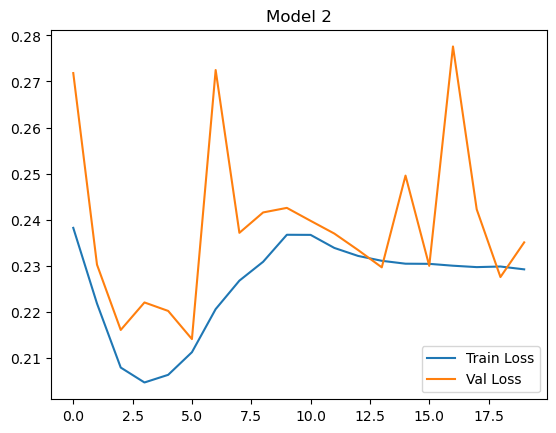

3
Resnet34
device :  cuda


100%|██████████| 380/380 [09:02<00:00,  1.43s/it]


Save model 3
Epoch 1/20, Train Loss: 0.25151, Val Loss: 0.25427, Elapsed Time: 994.52s, Estimated Time Left: 18895.95s


100%|██████████| 380/380 [06:25<00:00,  1.01s/it] 


Epoch 2/20, Train Loss: 0.23213, Val Loss: 0.26467, Elapsed Time: 400.53s, Estimated Time Left: 7209.60s


100%|██████████| 380/380 [02:05<00:00,  3.03it/s]


Save model 3
Epoch 3/20, Train Loss: 0.22002, Val Loss: 0.22735, Elapsed Time: 140.26s, Estimated Time Left: 2384.50s


100%|██████████| 380/380 [02:05<00:00,  3.03it/s]


Epoch 4/20, Train Loss: 0.21853, Val Loss: 0.23385, Elapsed Time: 140.12s, Estimated Time Left: 2241.98s


100%|██████████| 380/380 [02:05<00:00,  3.03it/s]


Epoch 5/20, Train Loss: 0.21947, Val Loss: 0.23323, Elapsed Time: 140.15s, Estimated Time Left: 2102.21s


100%|██████████| 380/380 [02:07<00:00,  2.98it/s]


Epoch 6/20, Train Loss: 0.22245, Val Loss: 0.23869, Elapsed Time: 142.03s, Estimated Time Left: 1988.46s


100%|██████████| 380/380 [02:05<00:00,  3.03it/s]


Epoch 7/20, Train Loss: 0.22873, Val Loss: 0.24345, Elapsed Time: 139.78s, Estimated Time Left: 1817.14s


100%|██████████| 380/380 [02:05<00:00,  3.04it/s]


Epoch 8/20, Train Loss: 0.23173, Val Loss: 0.25643, Elapsed Time: 139.73s, Estimated Time Left: 1676.75s


100%|██████████| 380/380 [02:08<00:00,  2.96it/s]


Epoch 9/20, Train Loss: 0.23365, Val Loss: 0.23644, Elapsed Time: 143.47s, Estimated Time Left: 1578.22s


100%|██████████| 380/380 [02:08<00:00,  2.96it/s]


Epoch 10/20, Train Loss: 0.23314, Val Loss: 0.24407, Elapsed Time: 142.90s, Estimated Time Left: 1428.98s


100%|██████████| 380/380 [02:06<00:00,  3.00it/s]


Save model 3
Epoch 11/20, Train Loss: 0.23188, Val Loss: 0.22720, Elapsed Time: 142.09s, Estimated Time Left: 1278.85s


100%|██████████| 380/380 [02:07<00:00,  2.97it/s]


Epoch 12/20, Train Loss: 0.23157, Val Loss: 0.24085, Elapsed Time: 142.32s, Estimated Time Left: 1138.52s


100%|██████████| 380/380 [02:05<00:00,  3.02it/s]


Epoch 13/20, Train Loss: 0.23068, Val Loss: 0.24069, Elapsed Time: 140.35s, Estimated Time Left: 982.42s


100%|██████████| 380/380 [02:08<00:00,  2.96it/s]


Epoch 14/20, Train Loss: 0.23021, Val Loss: 0.24048, Elapsed Time: 133.58s, Estimated Time Left: 801.47s


100%|██████████| 380/380 [01:50<00:00,  3.43it/s]


Epoch 15/20, Train Loss: 0.22994, Val Loss: 0.25032, Elapsed Time: 116.15s, Estimated Time Left: 580.75s


100%|██████████| 380/380 [01:51<00:00,  3.41it/s]


Epoch 16/20, Train Loss: 0.22921, Val Loss: 0.23760, Elapsed Time: 116.67s, Estimated Time Left: 466.68s


100%|██████████| 380/380 [01:50<00:00,  3.44it/s]


Epoch 17/20, Train Loss: 0.22900, Val Loss: 0.23872, Elapsed Time: 115.74s, Estimated Time Left: 347.22s


100%|██████████| 380/380 [01:50<00:00,  3.44it/s]


Epoch 18/20, Train Loss: 0.22882, Val Loss: 0.23447, Elapsed Time: 115.80s, Estimated Time Left: 231.60s


100%|██████████| 380/380 [01:50<00:00,  3.44it/s]


Epoch 19/20, Train Loss: 0.22918, Val Loss: 0.22979, Elapsed Time: 115.75s, Estimated Time Left: 115.75s


100%|██████████| 380/380 [01:50<00:00,  3.43it/s]


Epoch 20/20, Train Loss: 0.22832, Val Loss: 0.23112, Elapsed Time: 115.87s, Estimated Time Left: 0.00s
Finished Training


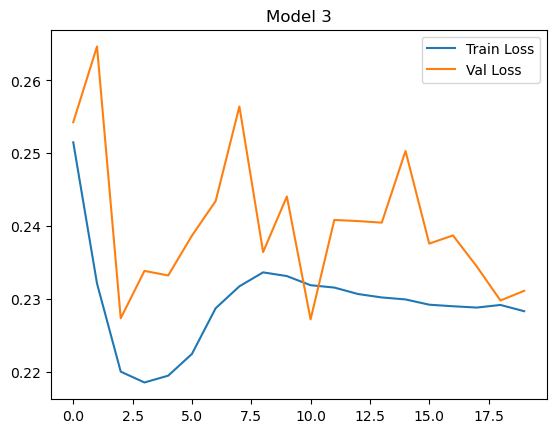

In [80]:
for i in range(1,4):
    print(i)
    model = ModelSelect(i)
    import torch
    import time
    import torch.nn as nn
    from torch.optim import Adam
    import matplotlib.pyplot as plt
    from torch.nn import DataParallel
    import platform
    device = 'mps' if platform.system() == 'Darwin' else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("device : ",device)
    # Create the model, loss function and optimizer
    model.to(device)
    if torch.cuda.device_count() > 1:  # Check if multiple GPUs are available
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = DataParallel(model)
        
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), weight_decay=0.01)  # Add weight decay for L2 regularization

    # For storing losses
    train_losses = []
    val_losses = []

    # Training loop
    num_epochs = 20
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in tqdm(train_loader):
            #print(inputs.shape)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        val_loss = running_loss / len(val_loader)
        val_losses.append(val_loss)

        # Save the model if it's the best so far
        if val_loss < best_loss:
            model_name = f'AI2_model{i}.pth'  # Unique name for each model
            torch.save(model.state_dict(), model_name)
            best_loss = val_loss
            print(f"Save model {i}")

        end_time = time.time()
        elapsed_time = end_time - start_time
        estimated_time = elapsed_time * (num_epochs - epoch - 1)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Elapsed Time: {elapsed_time:.2f}s, Estimated Time Left: {estimated_time:.2f}s")

    print("Finished Training")

    # Plot the losses
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Model {i}')  # label the plot with the model number
    plt.legend()
    plt.savefig(f'model_{i}_losses.png')  # save the figure as a png
    plt.show()

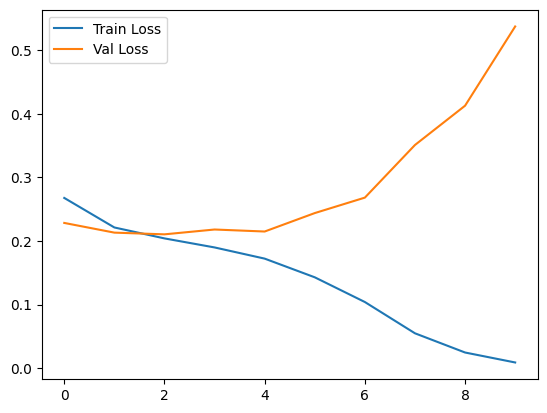

In [ ]:
# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [98]:
from sklearn.metrics import accuracy_score

def compute_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model outputs
            outputs = model(inputs)
            
            # Convert model outputs to probabilities
            probs = torch.sigmoid(outputs)
            
            # Convert probabilities to binary outputs
            preds = (probs > 0.5).float()
            
            # Compute the number of correct predictions
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.numel()
            
    accuracy = correct_predictions / total_predictions
    return accuracy
print(compute_accuracy(ModelSelect(3),val_loader,'cuda'))

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet34
0.5256705757199666


In [ ]:
# DEVICE

import sounddevice as sd
import librosa
import numpy as np
import torch

def get_mel_spectrogram(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # Compute the spectrogram
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D_abs = np.abs(D)
    # Convert to Mel scale
    mel_spec = librosa.feature.melspectrogram(S=librosa.amplitude_to_db(D_abs), sr=sr, n_mels=n_mels)
    return mel_spec

# Load the trained model
model = AudioClassifier()

try:
    model.load_state_dict(torch.load('AI2.pth'))
except:
    try:
        model.load_state_dict(torch.load('AI2.pth', map_location=torch.device('cpu')))
    except:
        state_dict = torch.load('AI2.pth', map_location=torch.device('cpu'))
        new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.eval()

# Record audio
duration = 2  # seconds
fs = 44100  # Sample rate
recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished

# Preprocess audio
recording = np.squeeze(recording)  # Remove the singleton dimension
recording = librosa.resample(recording, orig_sr=fs, target_sr=22050)  # Resample the recording
mel_spec = get_mel_spectrogram(recording)  # Compute the Mel spectrogram

# Make prediction
mel_spec = torch.from_numpy(mel_spec).unsqueeze(0).float()  # Add two singleton dimensions at the beginning
outputs = model(mel_spec)
probs = torch.nn.functional.softmax(outputs, dim=1)
top_prob, top_label = torch.max(probs, dim=1)

#print(f"Predicted label: {le.inverse_transform([top_label.item()])[0]}")
#print(f"Probability: {top_prob.item() * 100:.2f}%")
# Define the threshold
threshold = 0.0

# Apply threshold to probabilities
high_prob_mask = probs > threshold


# Convert probabilities tensor to numpy array
probs_array = probs.detach().numpy()

# Iterate over all labels and their corresponding probabilities
for label, prob in zip(mlb.classes_, probs_array[0]):
    print(f"Label: {label}, Probability: {prob * 100:.2f}%")

# Get labels for high-probability predictions

#high_prob_labels = le.inverse_transform(torch.where(high_prob_mask)[1])
# Get probabilities for high-confidence predictions
high_prob_probs = probs[high_prob_mask]

# Get labels for high-confidence predictions
high_prob_labels = mlb.inverse_transform(high_prob_mask.numpy())

# Convert high_prob_labels and high_prob_probs to lists
high_prob_labels = high_prob_labels[0]
high_prob_probs = high_prob_probs.tolist()

# Print labels and corresponding probabilities
for label, prob in zip(high_prob_labels, high_prob_probs):
    print(f"Predicted label: {label}, Probability: {prob * 100:.2f}%")


print(f"Predicted labels: {high_prob_labels}")


Predicted label: siren, Probability: 100.00%
Predicted labels: ('siren',)


# Diary
2023.07.24 0109i

I honestly spent like 15 hours to make this today. It took a lot of time but since I did 'urban 8 sound' before. It was slightly OK but still frustrating. I was almost done finishing this project then I noticed that some of the label has MORE than one label at a time. Then I have to do this whole thing over again . That was my first drag, and the second drag was at the fact I accidentally deleted the whole thing pressing undo in GitHub. Thankfully I had all the things in chat GPT, so that from there I was easily recovered.  
I still have a problem with real time analizer but I can sort it out later  
I have to go to work tommorrow, I have to go to sleep.  


2023.07.25 1555i
